# ABS Inflation multi-measure

## Python set-up

In [1]:
# system imports
from typing import Callable, Sequence
from functools import cache

# analytic imports
import pandas as pd
from pandas import DataFrame
import numpy as np
import readabs as ra
from readabs import metacol as mc
from math import isfinite

# local imports
from abs_helper import ANNUAL_CPI_TARGET_RANGE
from plotting import clear_chart_dir, line_plot, set_chart_dir, finalise_plot

In [2]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
CHART_DIR = "./CHARTS/Inflation/"
set_chart_dir(CHART_DIR)
clear_chart_dir(CHART_DIR)

# some plotting constants
LFOOTER = "Australia. Orig = Original series. SA = Seasonally adjusted series. "

# display charts in this notebook
SHOW = False

## Main comparative charts

### Download key ABS data

In [3]:
def download_abs(
    wanted: dict,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[str, str], str]:
    """Capture data from ABS using a wanted dictionary."""

    data, meta, abbr, sources = {}, {}, {}, []
    for series_id, (category_id, seo, title, abrev) in wanted.items():
        d, m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        series = d[series_id]
        if "IPD" in abrev:
            series = series.pct_change(4, fill_method=None) * 100
        if "Q" in m[mc.freq][series_id]:
            series = ra.qtly_to_monthly(series, interpolate=False)
        data[title] = series
        meta[title] = m.loc[series_id]
        abbr[title] = abrev
        sources.append(category_id)

    return (
        pd.DataFrame(data),
        pd.DataFrame(meta).T,
        abbr,
        f"ABS: {', '.join(sorted(set(sources)))}",
    )

### Multi-indicator plot

In [4]:
@cache
def get_headline_data() -> tuple[pd.DataFrame, pd.DataFrame, dict[str, str], str]:
    """Get a dictionary of data items from the ABS."""

    ipd = "5206005_Expenditure_Implicit_Price_Deflators"
    wanted = {
        # "Series ID": ["Category ID", "single-excel-only", "Short Series Title", "abbreviation"],
        "A128478318V": ["6484.0", "648401", "Monthly CPI (Orig)", "MCPI"],
        "A128481588C": ["6484.0", "648401", "Monthly CPI (SA)", "MCPISA"],
        "A130184497K": [
            "6484.0",
            "648401",
            "Monthly Trimmed Mean CPI (Orig)",
            "MCPITM",
        ],
        "A2325847F": ["6401.0", "640106", "Qtly CPI (Orig)", "CPI"],
        "A3604508K": ["6401.0", "640106", "Qtly CPI (SA)", "CPISA"],
        "A3604511X": ["6401.0", "640106", "Qtly Trimmed Mean CPI (SA)", "CPITM"],
        "A3604505C": ["6401.0", "640106", "Qtly Weighted Median CPI (SA)", "CPIWM"],
        "A2314867K": ["6427.0", "642701", "Producer Price Index (Orig)", "PPI"],
        "A83895396W": [
            "6345.0",
            "634501",
            "Wage Price Index (All sectors) (SA)",
            "WPI",
        ],
        "A2303940R": [
            "5206.0",
            ipd,
            "Household implicit price deflator (SA)",
            "HHIPD",
        ],
        "A2303727C": ["5206.0", ipd, "GNE implicit price deflator (SA)", "GNEIPD"],
    }

    return download_abs(wanted)

In [5]:
def plot_multi(
    starts: Sequence = (None, "2020-09-01", "2022-12-01"),
):
    """Plot multiple inflation indicators."""

    data, _meta, abbr, source = get_headline_data()
    last = pd.Series(data.ffill().iloc[-1]).rename(index=abbr)
    last_str = ", ".join([f"{k}={v:0.1f}" for k, v in last.items()])

    mixed_style = ["solid", "dotted", "dashed"] * 5
    marker_set = list("ov^<>8sp*HhdPX")
    styles = (None, mixed_style, mixed_style)
    markers = (None, marker_set, marker_set)
    tags = ("", " (recent)", " (latest)")

    for start, marker, style, tag in zip(starts, markers, styles, tags):
        d = data.loc[start:]
        line_plot(
            d,
            title=f"Inflation Indicators{tag}",
            ylabel="Per cent (through the year)",
            axhspan=ANNUAL_CPI_TARGET_RANGE,
            y0=True,
            rfooter=source,
            lheader=last_str,
            legend={
                "loc": "best",
                "fontsize": "8",
                "ncol": 2,
            },
            lfooter=LFOOTER,
            show=SHOW,
            marker=marker,
            markersize=4,
            style=style,
            dropna=True,
        )


plot_multi()

### Quarterly/Monthly CPI pairs

In [6]:
def plot_pairs(
    function: Callable,
    pairs: dict[str, tuple[str, str]],
    start: str = "2019-12-01",
    title_stem: str = "Monthly vs Quarterly",
) -> None:
    """Plot pairs of inflation indicators."""

    data, _meta, _abbr, source = function()
    data = data.loc[start:]
    for label, pair in pairs.items():
        d = data[list(pair)]
        line_plot(
            d,
            title=f"{label}: {title_stem}",
            ylabel="Per cent (through the year)",
            axhspan=ANNUAL_CPI_TARGET_RANGE,
            y0=True,
            rfooter=source,
            legend={"loc": "best", "fontsize": "8"},
            lfooter=LFOOTER,
            width=[1, 2],
            show=SHOW,
            dropna=True,
        )


headline_pairs = {
    # "label": ("quarterly series", "monthly series")
    "Headline CPI (Orig)": ("Qtly CPI (Orig)", "Monthly CPI (Orig)"),
    "Headline CPI (SA)": ("Qtly CPI (SA)", "Monthly CPI (SA)"),
    "Trimmed Mean CPI": (
        "Qtly Trimmed Mean CPI (SA)",
        "Monthly Trimmed Mean CPI (Orig)",
    ),
    "Weighted Median CPI": (
        "Qtly Weighted Median CPI (SA)",
        "Monthly Trimmed Mean CPI (Orig)",
    ),
}

plot_pairs(get_headline_data, headline_pairs)

In [7]:
@cache
def get_analytic_data() -> tuple[pd.DataFrame, pd.DataFrame, dict[str, str], str]:
    """Get a dictionary of data items from the ABS."""

    wanted = {
        # "Series ID": ["Category ID", "single-excel-only", "Short Series Title", "abbreviation"],
        "A128483462J": ["6484.0", "648401", "Monthly CPI Goods Component (Orig)", ""],
        "A128481640A": [
            "6484.0",
            "648401",
            "Monthly CPI Services Component (Orig)",
            "",
        ],
        "A128476506T": ["6484.0", "648401", "Monthly CPI Tradables (Orig)", ""],
        "A128480134T": ["6484.0", "648401", "Monthly CPI Non-tradables (Orig)", ""],
        "A130184498L": ["6484.0", "648401", "Monthly CPI Excluding Volatile (SA)", ""],
        "A2330617V": ["6401.0", "640106", "Qtly CPI Goods Component (Orig)", ""],
        "A2330707X": ["6401.0", "640106", "Qtly CPI Services Component (Orig)", ""],
        "A2330527R": ["6401.0", "640106", "Qtly CPI Tradables (Orig)", ""],
        "A2330572A": ["6401.0", "640106", "Qtly CPI Non-tradables (Orig)", ""],
        "A2330842R": ["6401.0", "640106", "Qtly CPI Excluding Volatile (Orig)", ""],
    }
    return download_abs(wanted)

In [8]:
analytic_pairs = {
    # "label": ("quarterly series", "monthly series")
    "CPI Goods Component": (
        "Qtly CPI Goods Component (Orig)",
        "Monthly CPI Goods Component (Orig)",
    ),
    "CPI Services": (
        "Qtly CPI Services Component (Orig)",
        "Monthly CPI Services Component (Orig)",
    ),
    "CPI Tradables": ("Qtly CPI Tradables (Orig)", "Monthly CPI Tradables (Orig)"),
    "CPI Non-tradables": (
        "Qtly CPI Non-tradables (Orig)",
        "Monthly CPI Non-tradables (Orig)",
    ),
    "CPI Excluding Volatile": (
        "Qtly CPI Excluding Volatile (Orig)",
        "Monthly CPI Excluding Volatile (SA)",
    ),
}

plot_pairs(get_analytic_data, analytic_pairs)

## Annualised monthly/quarterly

***But note***: a whole host of problems annualising the monthly series.
And the data does not exist to annualise the monthly trimmed mean CPI.

In [9]:
@cache
def get_index_data() -> pd.DataFrame:
    """Get a dictionary of data items from the ABS."""

    wanted = {
        # "Series ID": ["Category ID", "single-excel-only", "Short Series Title", "abbreviation", ""],
        "A2325846C": ["6401.0", "640106", "Qtly CPI (Orig)", ""],
        "A3604506F": ["6401.0", "640106", "Quartely CPI (SA)", ""],
        "A2330841L": ["6401.0", "640106", "Qtly CPI Excluding Volatile (Orig)", ""],
        "A2330616T": ["6401.0", "640106", "Qtly CPI Goods Component (Orig)", ""],
        "A2330706W": ["6401.0", "640106", "Qtly CPI Services Component (Orig)", ""],
        "A128478317T": ["6484.0", "648401", "Monthly CPI (Orig)", ""],
        "A128481587A": ["6484.0", "648401", "Monthly CPI (SA)", ""],
        "A128473239F": [
            "6484.0",
            "648401",
            "Monthly CPI Excluding Volatile (Orig)",
            "",
        ],
        "A128483461F": ["6484.0", "648401", "Monthly CPI Goods Component (Orig)", ""],
        "A128481639T": [
            "6484.0",
            "648401",
            "Monthly CPI Services Component (Orig)",
            "",
        ],
    }

    return download_abs(wanted)[0]

In [10]:
def annualise_plot() -> None:
    """Plot annualised inflation indicators."""

    # pairs we want to plot
    data: DataFrame = get_index_data()
    pairs = {
        # "label": ("quarterly series", "monthly series")
        "Headline CPI": ("Qtly CPI (Orig)", "Monthly CPI (Orig)"),
        "Headline CPI (SA)": ("Quartely CPI (SA)", "Monthly CPI (SA)"),
        "CPI Excluding Volatile": (
            "Qtly CPI Excluding Volatile (Orig)",
            "Monthly CPI Excluding Volatile (Orig)",
        ),
        "CPI Goods Component": (
            "Qtly CPI Goods Component (Orig)",
            "Monthly CPI Goods Component (Orig)",
        ),
        "CPI Services Component": (
            "Qtly CPI Services Component (Orig)",
            "Monthly CPI Services Component (Orig)",
        ),
    }

    # calculate annualised percentage changes and plot
    months_in_year = 12
    for months in 3, 6:
        pct_d = ra.percent_change(data, n_periods=months)
        pct_d = ra.annualise_percentages(pct_d, months_in_year / months)

        def fake_capture(dataset=pct_d):
            return dataset, DataFrame(), "ABS: 6401.0, 6484.0", ""

        plot_pairs(
            fake_capture,
            pairs,
            title_stem=f"{months} months annualised",
        )


annualise_plot()

## Recent Phillips Curve

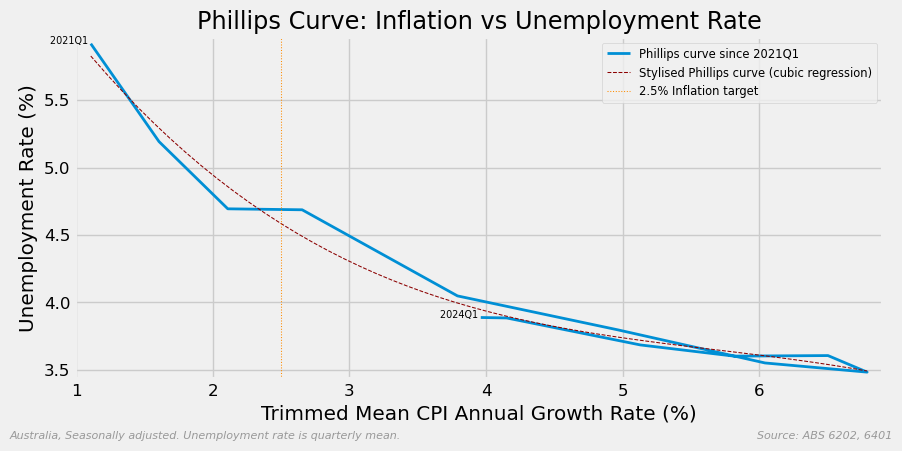

In [49]:
def phillips_curve() -> None:
    """Produce a Phillips Curve chart."""

    # trimmed mean annual inflation rate (seasonally adjusted)
    cpi, _ = ra.read_abs_series("6401.0", "A3604509L", single_excel_only="640106")
    tm_cpi = cpi["A3604509L"].pct_change(periods=4, fill_method=None) * 100

    # seasonally adjusted unemployment rate
    lfs, _ = ra.read_abs_series(
        "6202.0", ["A84423043C", "A84423047L"], single_excel_only="6202001"
    )
    ue_rate = ra.monthly_to_qtly(100 - (lfs["A84423043C"] / lfs["A84423047L"] * 100))

    # select recent data
    start = "2021Q1"
    frame = pd.DataFrame({"Trimmed Mean CPI": tm_cpi, "_Unemployment Rate": ue_rate})
    frame = frame.loc[start:]
    # Report quarterly unemployment rate before the quarterly CPI drops.
    last = frame.iloc[-1, 1] if not isfinite(frame.iloc[-1, 0]) else None
    last_date = frame.index[-1]
    frame = frame.dropna()  # drop the last row if it has a NaN

    # Fit a cubic regression line to the data
    model = np.poly1d(
        np.polyfit(frame["Trimmed Mean CPI"], frame["_Unemployment Rate"], 3)
    )
    polyline = np.linspace(
        frame["Trimmed Mean CPI"].min(), frame["Trimmed Mean CPI"].max(), 50
    )

    # plot
    ax = frame.plot(
        x="Trimmed Mean CPI",
        y="_Unemployment Rate",
        lw=2,
        label=f"Phillips curve since {start}",
    )
    ax.plot(
        polyline,
        model(polyline),
        color="darkred",
        linestyle="--",
        lw=0.75,
        label="Stylised Phillips curve (cubic regression)",
    )
    ax.axvline(
        2.5, color="darkorange", linestyle=":", lw=0.75, label="2.5% Inflation target"
    )
    if last:
        ax.axhline(
            last,
            color="darkgreen",
            linestyle="-.",
            lw=0.75,
            label=f"Unemployment rate {last_date}",
        )
    for n in (0, -1):
        # Label the start and end
        ax.text(
            frame["Trimmed Mean CPI"].iloc[n],
            frame["_Unemployment Rate"].iloc[n],
            f"{frame.index[n]} ",
            fontsize="xx-small",
            ha="right",
        )
    finalise_plot(
        ax,
        title="Phillips Curve: Inflation vs Unemployment Rate",
        ylabel="Unemployment Rate (%)",
        xlabel="Trimmed Mean CPI Annual Growth Rate (%)",
        lfooter="Australia, Seasonally adjusted. Unemployment rate is quarterly mean. ",
        rfooter="Source: ABS 6202, 6401",
        legend={"fontsize": "x-small", "loc": "upper right"},
        show=True,
    )


phillips_curve()

## Beveridge curve

,index,Data Item Description,Series Type,Series ID,Series Start,Series End,No. Obs.,Unit,Data Type,Freq.,Collection Month,Table,Table Description,Catalogue number
A84423043C,2,Employed total ; Persons ;,Seasonally Adjusted,A84423043C,1978-02-01 00:00:00,2024-05-01 00:00:00,556.0,000,STOCK,Month,1.0,6202001,"Labour force status by Sex, Australia - Trend, Seasonally adjusted and Original",6202.0
A84423047L,92,Labour force total ; Persons ;,Seasonally Adjusted,A84423047L,1978-02-01 00:00:00,2024-05-01 00:00:00,556.0,000,STOCK,Month,1.0,6202001,"Labour force status by Sex, Australia - Trend, Seasonally adjusted and Original",6202.0


,index,Data Item Description,Series Type,Series ID,Series Start,Series End,No. Obs.,Unit,Data Type,Freq.,Collection Month,Table,Table Description,Catalogue number
A590698F,10,Job Vacancies ; Australia ;,Seasonally Adjusted,A590698F,1979-05-15 00:00:00,2024-05-15 00:00:00,181.0,000,STOCK,Quarter,2.0,6354001,"Job Vacancies, States and Territories ('000)",6354.0


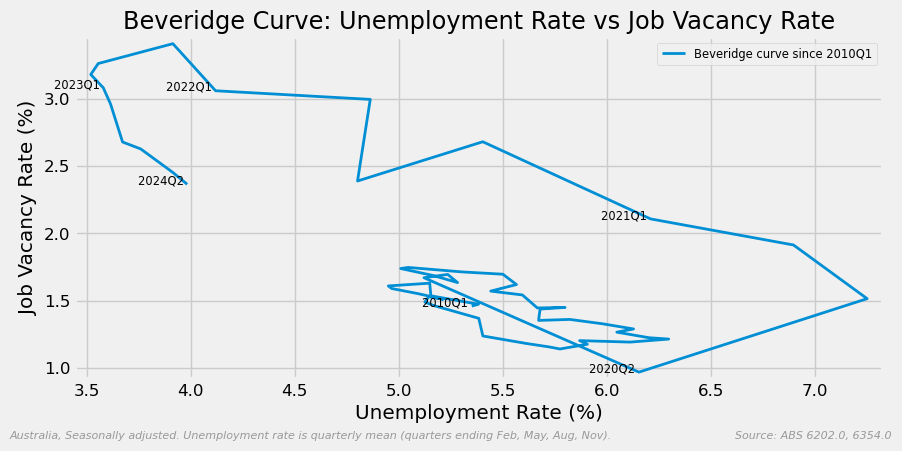

In [77]:
def beveridge_curve() -> None:

    # Collect data for the next chart
    lfs, _ = ra.read_abs_series(
        "6202.0", ["A84423043C", "A84423047L"], single_excel_only="6202001"
    )
    display(_)  # show the metadata
    ue_rate_q = ra.monthly_to_qtly(100 - (lfs["A84423043C"] / lfs["A84423047L"] * 100), q_ending="NOV")
    la, _  = ra.read_abs_series("6354.0", "A590698F", single_excel_only="6354001")
    display(_)  # show the metadata
    vr = la["A590698F"] / ra.monthly_to_qtly(lfs["A84423047L"], q_ending="NOV")  * 100
    frame = pd.DataFrame({"Unemployment Rate": ue_rate_q, "Job Vacancy Rate": vr})
    start = "2010Q2"
    f = frame.loc[start:].dropna()

    # Fit a cubic regression line to the data
    model = np.poly1d(
        np.polyfit(f["Unemployment Rate"], f["Job Vacancy Rate"], 3)
        )
    polyline = np.linspace(
        f["Unemployment Rate"].min(), f["Unemployment Rate"].max(), 50
    )

    # Plot the next chart
    ax = f.plot(
        x="Unemployment Rate",
        y="Job Vacancy Rate",
        lw=2,
        label=f"Beveridge curve since {f.index[0]}",
    )
    #ax.plot(
    #        polyline,
    #        model(polyline),
    #        color="darkred",
    #        linestyle="--",
    #        lw=0.75,
    #        label="Stylised Beveridge curve (cubic regression)",
    #)

    for n in (f.index[0], f.index[-1], 
        pd.Period("2020Q2", freq="Q-NOV"),
        pd.Period("2021Q1", freq="Q-NOV"),
        pd.Period("2022Q1", freq="Q-NOV"),
        pd.Period("2023Q1", freq="Q-NOV"),
        #pd.Period("2024Q1", freq="Q-NOV"),
    ):
        # Label the start and end
        ax.text(
            f["Unemployment Rate"].loc[n],
            f["Job Vacancy Rate"].loc[n],
            f"{n} ",
            fontsize="x-small",
            ha="right",
        )
    finalise_plot(
        ax,
        title="Beveridge Curve: Unemployment Rate vs Job Vacancy Rate",
        ylabel="Job Vacancy Rate (%)",
        xlabel="Unemployment Rate (%)",
        lfooter="Australia, Seasonally adjusted. Unemployment rate is quarterly mean "
        + "(quarters ending Feb, May, Aug, Nov).",
        rfooter="Source: ABS 6202.0, 6354.0",
        legend={"fontsize": "x-small", "loc": "upper right"},
        show=True,
    )


beveridge_curve()

## Finished

In [13]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Jul 07 2024 20:04:32

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

numpy  : 1.26.4
pandas : 2.2.2
readabs: 0.0.6

Watermark: 2.4.3



In [14]:
print("Finished")

Finished
